# ANC Ollama: Wikipedia + FAISS + Ollama (Databricks-Parity)

This notebook mirrors the `Config` and `Wikipedia Data Loader` sections from
`docs/ideation-kernel/01_agentic_wikipedia_aimpoint_interview.ipynb`, but swaps
Databricks components for local Ollama components on macOS.

Provider mapping used here:
- `ChatDatabricks` -> `ChatOllama`
- `DatabricksEmbeddings` -> `OllamaEmbeddings`
- Same `WikipediaLoader` + `FAISS` retrieval flow


## Workflow Diagram

This diagram matches the current notebook flow:

1. Define config (`query_terms`, `max_docs`, `k`, embedding model, chat model).
2. Load Wikipedia documents with `WikipediaLoader`.
3. Split documents into chunks for predictable embedding latency.
4. Build FAISS incrementally in batches and persist to disk (`~/DATA/naturalist-companion/faiss/anc_ollama` by default).
5. Run similarity search for the example question.
6. Generate an answer with `ChatOllama`.

Run the next code cell to render the diagram inline.

Execution is split into `Stage 1/3`, `Stage 2/3`, and `Stage 3/3` with timing/status prints and heartbeat logs.


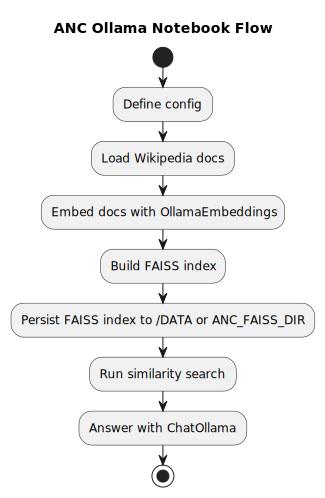

In [1]:
from IPython.display import Markdown, SVG, display
import requests

PLANTUML_SOURCE = """
@startuml
title ANC Ollama Notebook Flow
start
:Define config;
:Load Wikipedia docs;
:Embed docs with OllamaEmbeddings;
:Build FAISS index;
:Persist FAISS index to ~/DATA or ANC_FAISS_DIR;
:Run similarity search;
:Answer with ChatOllama;
stop
@enduml
"""


def render_plantuml(source: str) -> None:
    errors = []

    # Preferred path: Python PlantUML client (if installed).
    try:
        from plantuml import PlantUML  # type: ignore

        client = PlantUML(url="http://www.plantuml.com/plantuml/svg/")
        svg_url = client.get_url(source)
        resp = requests.get(svg_url, timeout=20)
        resp.raise_for_status()
        display(SVG(resp.text))
        return
    except Exception as exc:
        errors.append(f"plantuml library renderer failed: {exc}")

    # Fallback path: Kroki PlantUML HTTP endpoint.
    try:
        resp = requests.post(
            "https://kroki.io/plantuml/svg",
            data=source.encode("utf-8"),
            headers={"Content-Type": "text/plain"},
            timeout=20,
        )
        resp.raise_for_status()
        display(SVG(resp.text))
        return
    except Exception as exc:
        errors.append(f"kroki renderer failed: {exc}")

    display(Markdown("PlantUML render failed. Showing source and errors."))
    for item in errors:
        print(item)
    print('\nPlantUML source:\n')
    print(source)


render_plantuml(PLANTUML_SOURCE)


In [2]:
# Uncomment in fresh environments:

# %pip install -q -r ../requirements-ollama-dev.txt

# %pip install -q plantuml

# %pip install -q ipywidgets

# %pip install -q jupyterlab_widgets


In [3]:
#######################################################################################################

###### Python Package Imports for this notebook                                                  ######

#######################################################################################################


import os
import warnings
from threading import Event, Thread

# Mitigate common macOS OpenMP duplicate-library crashes in notebook kernels.
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

# Silence noisy tqdm widget warning in IDE notebooks when rich progress widgets are unavailable.
warnings.filterwarnings("ignore", message=".*IProgress not found.*")


# LangChain moved WikipediaLoader in newer releases; keep backward compatibility.
try:
    from langchain_community.document_loaders import WikipediaLoader
except ImportError:
    from langchain.document_loaders import WikipediaLoader

try:
    from langchain_text_splitters import RecursiveCharacterTextSplitter
except ImportError:
    from langchain.text_splitter import RecursiveCharacterTextSplitter

import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_ollama import ChatOllama, OllamaEmbeddings


def _start_heartbeat(label: str, every_s: float = 8.0):
    stop = Event()

    def _run():
        elapsed = 0.0
        while not stop.wait(every_s):
            elapsed += every_s
            print(f"[{label}] still running... {elapsed:.0f}s elapsed")

    thread = Thread(target=_run, daemon=True)
    thread.start()
    return stop


try:
    import ipywidgets as _ipywidgets
    print(f"[env] ipywidgets detected: v{_ipywidgets.__version__}")
except Exception:
    print("[env] ipywidgets not found in this kernel. Run `%pip install -q ipywidgets` and restart the kernel.")


#######################################################################################################

###### Config (Define LLMs, Embeddings, Vector Store, Data Loader specs)                         ######

#######################################################################################################


# DataLoader Config
query_terms = [
    "roadcut",
    "geology",
    "sedimentary rock",
    "stratigraphy",
]
max_docs = 3  # Fast local iteration setting.

# Stage 2 chunking + batching controls (keep small for interactive runs).
chunk_size = 1200
chunk_overlap = 150
embedding_batch_size = 8


# Retriever Config
k = 1
EMBEDDING_MODEL = "nomic-embed-text"
OLLAMA_BASE_URL = "http://localhost:11434"


# LLM Config
LLM_MODEL = "llama3.1:8b"
TEMPERATURE = 0.0


example_question = "I am on I-81 near Hagerstown with a 30-minute detour. Where can I safely stop to observe folded Valley-and-Ridge strata, and what exactly should I look for?"

# Response style controls (Roadside Geology audience: curious drivers, practical field learners).
RESPONSE_TONE = "field-guide"
MAX_BULLETS_PER_SECTION = 4

example_questions = [
    "I am driving I-81 near Bristol, TN. Give me two legal pull-off stops where I can see clear sedimentary layering, and tell me exactly what to look for.",
    "Near I-81 between Winchester and Strasburg, where can I safely stop to see Valley-and-Ridge structure, and what field clues confirm folding?",
    "I have 45 minutes near Hagerstown, MD. What roadside geology stop gives the best payoff for a beginner, and what story does the outcrop tell?",
    "Along I-81 in the Shenandoah Valley, point me to a short-walk stop to compare rock type and landform, then explain why that match matters.",
    "On an I-81 drive day, suggest one stop where I can observe evidence of ancient seas or sediment transport, with specific visual clues.",
]


[env] ipywidgets not found in this kernel. Run `%pip install -q ipywidgets` and restart the kernel.


In [4]:
#######################################################################################################

###### Stage 1/3: Wikipedia Data Load                                                            ######

#######################################################################################################


from time import perf_counter

print("[stage 1/3] Starting Wikipedia document load...")
query = " ".join(query_terms) if isinstance(query_terms, list) else query_terms
print(f"[stage 1/3] query={query!r}, max_docs={max_docs}")

heartbeat = _start_heartbeat("stage 1/3 wikipedia load", every_s=8.0)
t0 = perf_counter()
try:
    docs = WikipediaLoader(query=query, load_max_docs=max_docs).load()
finally:
    heartbeat.set()
t1 = perf_counter()

print(f"[stage 1/3] Loaded {len(docs)} document(s) in {t1 - t0:.2f}s")
if not docs:
    raise RuntimeError("No documents loaded from Wikipedia. Adjust query_terms/max_docs and re-run stage 1.")

print("[stage 1/3] Sample titles:")
for i, doc in enumerate(docs[:3], start=1):
    title = str((doc.metadata or {}).get("title") or f"doc_{i}")
    source = str((doc.metadata or {}).get("source") or "n/a")
    print(f"  {i}. {title} ({source})")


[stage 1/3] Starting Wikipedia document load...
[stage 1/3] query='roadcut geology sedimentary rock stratigraphy', max_docs=3


[stage 1/3] Loaded 3 document(s) in 2.51s
[stage 1/3] Sample titles:
  1. Carboniferous (https://en.wikipedia.org/wiki/Carboniferous)
  2. Paleomagnetism (https://en.wikipedia.org/wiki/Paleomagnetism)
  3. Artinskian (https://en.wikipedia.org/wiki/Artinskian)


In [5]:
#######################################################################################################

###### Stage 2/3: Build + Save FAISS Index, Then Retrieve                                        ######

#######################################################################################################


import os
from pathlib import Path
from time import perf_counter

if "docs" not in globals() or not docs:
    raise RuntimeError("`docs` not found. Run Stage 1/3 first.")

print(f"[stage 2/3] Building embeddings with model={EMBEDDING_MODEL!r} at {OLLAMA_BASE_URL!r}...")
print(
    f"[stage 2/3] Chunking docs with chunk_size={chunk_size}, chunk_overlap={chunk_overlap}, "
    f"embedding_batch_size={embedding_batch_size}"
)

splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
split_docs = splitter.split_documents(docs)
if not split_docs:
    raise RuntimeError("Chunking produced 0 documents. Adjust chunk_size/chunk_overlap and retry.")

total_chars = sum(len(str(d.page_content or "")) for d in split_docs)
print(f"[stage 2/3] Prepared {len(split_docs)} chunk(s), total_chars={total_chars}")

embeddings = OllamaEmbeddings(model=EMBEDDING_MODEL, base_url=OLLAMA_BASE_URL)

batch_size = max(1, int(embedding_batch_size))
vector_store = None

heartbeat = _start_heartbeat("stage 2/3 embedding/index", every_s=8.0)
t2 = perf_counter()
try:
    for start in range(0, len(split_docs), batch_size):
        batch = split_docs[start : start + batch_size]
        b0 = perf_counter()
        if vector_store is None:
            vector_store = FAISS.from_documents(batch, embeddings)
        else:
            vector_store.add_documents(batch)
        b1 = perf_counter()

        done = min(start + batch_size, len(split_docs))
        pct = (100.0 * done) / len(split_docs)
        print(
            f"[stage 2/3] Embedded batch {start // batch_size + 1}: "
            f"{done}/{len(split_docs)} chunks ({pct:.1f}%) in {b1 - b0:.2f}s"
        )
finally:
    heartbeat.set()

t3 = perf_counter()
if vector_store is None:
    raise RuntimeError("Vector store was not created.")

print(f"[stage 2/3] Built FAISS index in {t3 - t2:.2f}s")


faiss_base = os.environ.get("ANC_FAISS_DIR", "").strip()
if faiss_base:
    faiss_dir = (Path(faiss_base).expanduser() / "anc_ollama").resolve()
else:
    faiss_dir = (Path.home() / "DATA" / "naturalist-companion" / "faiss" / "anc_ollama").resolve()

faiss_dir.mkdir(parents=True, exist_ok=True)
vector_store.save_local(str(faiss_dir))
print(f"[stage 2/3] Saved FAISS index to: {faiss_dir}")


print(f"[stage 2/3] Running similarity search for question={example_question!r}, k={k}...")
results = vector_store.similarity_search(example_question, k=k)
print(f"[stage 2/3] Retrieved {len(results)} result(s)")

for i, res in enumerate(results, start=1):
    title = str((res.metadata or {}).get("title") or f"result_{i}")
    source = str((res.metadata or {}).get("source") or "n/a")
    snippet = str(res.page_content or "")[:220].replace("\\n", " ")
    print(f"  {i}. {title} ({source})")
    print(f"     {snippet}...")


[stage 2/3] Building embeddings with model='nomic-embed-text' at 'http://localhost:11434'...
[stage 2/3] Chunking docs with chunk_size=1200, chunk_overlap=150, embedding_batch_size=8
[stage 2/3] Prepared 14 chunk(s), total_chars=11001


[stage 2/3] Embedded batch 1: 8/14 chunks (57.1%) in 0.64s
[stage 2/3] Embedded batch 2: 14/14 chunks (100.0%) in 0.11s
[stage 2/3] Built FAISS index in 0.75s
[stage 2/3] Saved FAISS index to: /Users/ryan/DATA/naturalist-companion/faiss/anc_ollama
[stage 2/3] Running similarity search for question='I am on I-81 near Hagerstown with a 30-minute detour. Where can I safely stop to observe folded Valley-and-Ridge strata, and what exactly should I look for?', k=1...
[stage 2/3] Retrieved 1 result(s)
  1. Carboniferous (https://en.wikipedia.org/wiki/Carboniferous)
     The similarity in successions between the British Isles and Western Europe led to the development of a common European timescale with the Carboniferous System divided into the lower Dinantian, dominated by carbonate depo...


In [6]:
#######################################################################################################

###### Stage 3/3: Generate Answer with ChatOllama                                                ######

#######################################################################################################


from time import perf_counter

if "vector_store" not in globals():
    raise RuntimeError("`vector_store` not found. Run Stage 2/3 first.")

print(f"[stage 3/3] Generating answer with model={LLM_MODEL!r} at {OLLAMA_BASE_URL!r}...")
llm = ChatOllama(model=LLM_MODEL, base_url=OLLAMA_BASE_URL, temperature=TEMPERATURE)

voice_instructions = f"""
You are writing in a concise Roadside Geology field-guide voice for curious drivers.
Tone:
- Plainspoken, observant, and practical (not academic).
- Emphasize what can be seen from legal/safe pull-offs or short walks.
- Explain key geology in everyday language, then add one precise term when useful.
- Include safety and access realism (do not suggest unsafe roadside behavior).
Output format:
1) "Where to stop" (up to {MAX_BULLETS_PER_SECTION} bullets)
2) "What to look for" (up to {MAX_BULLETS_PER_SECTION} bullets)
3) "Why it matters" (2-4 sentences)
4) "Citations" (Wikipedia URLs only)
""".strip()


def _context_for_question(question: str, top_k: int = 2) -> str:
    local_results = vector_store.similarity_search(question, k=max(1, top_k))
    lines = []
    for i, res in enumerate(local_results, start=1):
        title = str((res.metadata or {}).get("title") or f"result_{i}")
        source = str((res.metadata or {}).get("source") or "n/a")
        snippet = str(res.page_content or "")[:450].replace("\n", " ")
        lines.append(f"[{i}] {title} ({source}) :: {snippet}")
    return "\n".join(lines)


def answer_question(question: str) -> str:
    context_block = _context_for_question(question, top_k=max(1, k))
    prompt = (
        f"Use only the provided Wikipedia-grounded context when you can.\n\n"
        f"Question: {question}\n\n"
        f"Context:\n{context_block}\n\n"
        f"Style requirements:\n{voice_instructions}"
    )

    heartbeat = _start_heartbeat("stage 3/3 llm", every_s=8.0)
    t0 = perf_counter()
    try:
        response = llm.invoke(prompt)
    finally:
        heartbeat.set()
    dt = perf_counter() - t0
    print(f"[stage 3/3] LLM response received in {dt:.2f}s")
    return str(response.content)


print(f"[stage 3/3] Primary question:\n- {example_question}")
primary_answer = answer_question(example_question)
print("\nAnswer:\n")
print(primary_answer)


[stage 3/3] Generating answer with model='llama3.1:8b' at 'http://localhost:11434'...


[stage 3/3] Primary question:
- I am on I-81 near Hagerstown with a 30-minute detour. Where can I safely stop to observe folded Valley-and-Ridge strata, and what exactly should I look for?


[stage 3/3 llm] still running... 8s elapsed


[stage 3/3] LLM response received in 14.22s

Answer:

**Where to Stop**

*   **Hagerstown Rest Area**: A safe and accessible spot on I-81, about 1 mile north of Hagerstown. You can observe the folded Valley-and-Ridge strata from the parking area or take a short walk along the adjacent trail.
*   **Antietam National Battlefield Visitor Center**: Located just off I-81, this visitor center offers a safe and informative stop to learn about the geology of the area. Take a short walk around the center's grounds to observe the folded strata.
*   **C&O Canal Towpath**: Park at one of the many parking areas along the towpath and take a short walk north or south to observe the folded Valley-and-Ridge strata.

**What to Look For**

*   **Folded Strata**: Observe how the layers of rock have been bent and folded due to tectonic forces. This is an example of a **thrust fault**, where older rocks are pushed over younger rocks.
*   **Valley-and-Ridge Structure**: Notice how the folded strata create a 

In [7]:
#######################################################################################################

###### Stage 3b/3: Run All Example Questions                                                     ######

#######################################################################################################


if "answer_question" not in globals():
    raise RuntimeError("`answer_question` not found. Run Stage 3/3 first.")

if "example_questions" not in globals() or not example_questions:
    raise RuntimeError("`example_questions` is empty. Check config cell.")

all_answers = []
print(f"[stage 3b/3] Running {len(example_questions)} example question(s)...")

for i, q in enumerate(example_questions, start=1):
    print("\n" + "=" * 110)
    print(f"[stage 3b/3] Question {i}/{len(example_questions)}")
    print(q)
    print("=" * 110)

    answer = answer_question(q)
    all_answers.append({"question": q, "answer": answer})

    print("\nResponse:\n")
    print(answer)

print(f"\n[stage 3b/3] Completed {len(all_answers)} question(s).")


[stage 3b/3] Running 5 example question(s)...

[stage 3b/3] Question 1/5
I am driving I-81 near Bristol, TN. Give me two legal pull-off stops where I can see clear sedimentary layering, and tell me exactly what to look for.


[stage 3/3 llm] still running... 8s elapsed


[stage 3/3] LLM response received in 10.03s

Response:

**Stop and Look: Sedimentary Layering on I-81 near Bristol, TN**

**Where to stop:**

*   **Exit 69**: Take the exit for US-11E/US-19E towards Kingsport. Park in the designated parking area near the highway.
*   **Exit 72**: Exit onto VA-75/VA-91 towards Abingdon. Look for a small parking lot on the right side of the road, just before the highway curves.

**What to look for:**

*   **Layered rock formations**: Observe the visible layering in the rocks, which can be seen as alternating bands of different colors or textures.
*   **Fossilized river deposits**: Look for fossils of ancient plants and animals embedded within the sedimentary layers.
*   **Erosion patterns**: Note how the rock layers have been shaped by erosion over time, creating unique features like arches or caves.

**Why it matters:**

The visible layering in these rocks is a result of the process of sedimentation, where particles settle out of water and accumulate ov

[stage 3/3 llm] still running... 8s elapsed


[stage 3/3] LLM response received in 10.52s

Response:

**Valley-and-Ridge Structure along I-81**

**Where to stop:**
* Safe pull-off near Winchester, VA, just north of I-81 exit 310
* Strasburg, VA, at the parking area for the Shenandoah Valley Discovery Museum (0.5 miles from I-81 exit 273)
* Short walk from the parking lot of the Strasburg Historic District (I-81 exit 273)
* Rest stop near Strasburg, VA, with a short walk to the nearby outcrop

**What to look for:**
* Exposed bedrock showing alternating layers of limestone and sandstone
* Folded rock layers, visible as a series of gentle, rounded hills
* Evidence of tectonic uplift, such as fault lines or fractures in the rock
* A prominent change in rock type and color, indicating a contact between different geological formations

**Why it matters:**
The Valley-and-Ridge structure is a classic example of a fold mountain range, formed when tectonic forces pushed up the Earth's crust during the Alleghanian orogeny (https://en.wikiped

[stage 3/3 llm] still running... 8s elapsed


[stage 3/3] LLM response received in 8.45s

Response:

**Roadside Geology Stop:**

* **Where to stop:** Take exit 5B from I-81 near Hagerstown, MD. Look for a small parking area on the north side of the highway.
* Alternatively, take exit 2A and head east on US-11 towards Sharpsburg, MD. Park at the Antietam National Battlefield visitor center.

**What to look for:**

* **Exposure:** A short walk from the parking area will reveal a roadcut exposing a sequence of red and gray sandstones.
* **Layering:** Observe the alternating layers of red and gray rock, which indicate changes in ancient river flow patterns.
* **Fossils:** Keep an eye out for fossils of ancient plants and animals embedded within the sandstone.

**Why it matters:**
This exposure tells a story of a changing environment during the Artinskian age (290.1-283.3 Ma). The red and gray sandstones represent different types of sediment deposited by rivers, which were likely influenced by shifting sea levels and climate conditions

[stage 3/3 llm] still running... 8s elapsed


[stage 3/3] LLM response received in 10.07s

Response:

**Where to Stop**

*   Exit I-81 at Winchester, Virginia (Exit 310), and head north on US-11.
*   Continue for approximately 10 miles until you reach the town of Stephenson, VA.
*   Look for a small parking area near the intersection of US-11 and VA-277.
*   Alternatively, stop at the Shenandoah National Park's Dickey Ridge Visitor Center (milepost 50.7) and take a short walk to the nearby overlook.

**What to Look For**

*   Observe the rock formations along the roadside, particularly those composed of limestone and sandstone.
*   Note the presence of fossils in these rocks, such as brachiopods or crinoids.
*   Take note of the landforms surrounding you, including hills, valleys, and ridges.
*   Look for any signs of erosion or weathering on the rock surfaces.

**Why it Matters**

The Artinskian age is characterized by a significant change in the Earth's climate, leading to the formation of new rock types and landforms. The limes

[stage 3/3 llm] still running... 8s elapsed


[stage 3/3] LLM response received in 10.51s

Response:

**I-81 Drive Day Stop:**

* **Stop 1:** Rest Area near Hagerstown, MD (mile marker 57.5)
* **Alternative Stop:** Sidewalk or parking area at Cumberland Gap National Historical Park, VA (near mile marker 137)

**What to Look For:**

* **Ancient Sea Clues:** Look for layered rock formations with visible sedimentary structures, such as cross-bedding or ripple marks.
* **Sediment Transport Evidence:** Observe the presence of conglomerate rocks, which are composed of rounded gravel and pebbles cemented together. This indicates that these rocks were formed from transported sediments (https://en.wikipedia.org/wiki/Conglomerate).
* **Fossilized Shells:** Keep an eye out for fossilized shells or other marine fossils embedded in the rock.
* **Rock Layers:** Note the visible layering of different rock types, which can indicate changes in sea level or sediment transport patterns.

**Why it Matters:**

The rocks you see here are a testament to

## Local Ollama Prerequisites (macOS)

- Ensure Ollama is installed and running: `ollama serve`
- Pull the embedding model: `ollama pull nomic-embed-text`
- Pull the chat model used in this notebook: `ollama pull llama3.1:8b`
- Keep `notebooks/anc_dbrx.ipynb` for Databricks-specific libraries and endpoints
- Keep `notebooks/anc_gcp.ipynb` for Vertex AI-specific libraries and endpoints

- If you hit macOS OpenMP kernel crashes, launch Jupyter with `KMP_DUPLICATE_LIB_OK=TRUE`.
- Optional PlantUML Python library: `pip install plantuml`

- Optional smaller/faster local model: `ollama pull llama3.2:3b`
- If you see `TqdmWarning: IProgress not found`, run `pip install ipywidgets jupyterlab_widgets` in this env, then restart the kernel.
- The notebook now suppresses this warning, but installing widgets is still recommended.

### PyCharm Notebook Stability Tips

- Ensure the notebook kernel points to this project interpreter: `/Users/ryan/Developer/naturalist-companion/.venv/bin/python`.
- After dependency changes, do **Kernel -> Restart Kernel and Run All Above**.
- Keep one notebook kernel active at a time while testing local Ollama.
- If you see repeated kernel restarts, reduce load first (`max_docs=2`, `chunk_size=800`, `embedding_batch_size=4`) and retry.
- If restarts persist, run the same notebook from terminal Jupyter once to compare behavior: `uv run jupyter lab`.

## I-81 Roadside-Geology Query Starters (Book-Style Audience)

Use prompts like these for readers who want practical, safe, observation-first geology guidance:

- "I am driving I-81 near Bristol, TN. Give me two legal pull-off stops where I can see clear sedimentary layering, and tell me exactly what to look for."
- "Near I-81 between Winchester and Strasburg, where can I safely stop to see Valley-and-Ridge structure, and what field clues confirm folding?"
- "I have 45 minutes near Hagerstown, MD. What roadside geology stop gives the best payoff for a beginner, and what story does the outcrop tell?"
- "Along I-81 in the Shenandoah Valley, point me to a short-walk stop to compare rock type and landform, then explain why that match matters."
- "On an I-81 drive day, suggest one stop where I can observe evidence of ancient seas or sediment transport, with specific visual clues."

Tip: Include your nearest city/exit and max detour minutes in the question for better stop recommendations.
